<a href="https://colab.research.google.com/github/NguyenDuy1910/LSTM-RNN-Project/blob/main/Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install tensorflow==2.14.0


In [3]:
import numpy as np
import tensorflow as tf

In [5]:
!pip install -q datasets
!pip install -q transformers
!pip install -q tf-models-official

Check GPU Working


In [6]:
import os
if os.environ['COLAB_TPU_ADDR']:
    cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
    tf.config.experimental_connect_to_cluster(cluster_resolver)
    tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
    strategy = tf.distribute.TPUStrategy(cluster_resolver)
    print('Using TPU')
    print("All devices: ", tf.config.list_logical_devices('TPU'))
elif tf.test.is_gpu_available():
    strategy = tf.distribute.MirroredStrategy()
    print('Using GPU')
else: raise ValueError('Running on CPU is not recommended.')

Using TPU
All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [7]:
import pandas as pd
import re

aspects = ['SCREEN', 'CAMERA', 'BATTERY', 'PERFORMANCE',
           'STORAGE', 'DESIGN', 'PRICE', 'GENERAL', 'SER&ACC']

id2pol_mapping = ['None', 'Positive', 'Neutral', 'Negative']
pol2id_mapping = {id2pol_mapping[i]: i for i in range(len(id2pol_mapping))}
def convert_label (label):
  res = {}
  t = re.findall(r'[\w&]+', label)
  features_index = None
  for i, item in enumerate(t):
        if item == 'FEATURES':
            features_index = i
            break

  if features_index is not None:
        # Nếu 'FEATURES' được tìm thấy, loại bỏ nó và giá trị tương ứng
        del t[features_index:features_index + 2]
  if 'OTHERS' in t:
    t.remove('OTHERS')



  for i in range(0, len(t), 2):
    res[t[i]] = pol2id_mapping[t[i + 1]]
  return res

def convert_data_format(in_file_path, out_file_path, aspects):
  df = pd.read_csv(in_file_path)

  # Add new columns
  for aspect in aspects:
    df[aspect] = pol2id_mapping['None']

  # Iterate through all samples
  for i in range(len(df)):
    label = convert_label(df.iloc[i]['label'])
    for asp, pol in label.items():
      df.at[i, asp] = pol

  df = df.drop(['index', 'n_star', 'date_time', 'label'], axis=1)
  df.to_csv(out_file_path, index=False)

convert_data_format('/content/drive/MyDrive/Colab Notebooks/draw-data/Train.csv', '/content/drive/MyDrive/Colab Notebooks/prepprocessed-data/TrainPrep.csv', aspects)
convert_data_format('/content/drive/MyDrive/Colab Notebooks/draw-data/Dev.csv', '/content/drive/MyDrive/Colab Notebooks/prepprocessed-data/DevPrep.csv', aspects)
convert_data_format('/content/drive/MyDrive/Colab Notebooks/draw-data/Test.csv', '/content/drive/MyDrive/Colab Notebooks/prepprocessed-data/TestPrep.csv', aspects)

In [8]:
TRAIN_PATH = '/content/drive/MyDrive/Colab Notebooks/prepprocessed-data/TrainPrep.csv'
VAL_PATH = '/content/drive/MyDrive/Colab Notebooks/prepprocessed-data/DevPrep.csv'
TEST_PATH =  '/content/drive/MyDrive/Colab Notebooks/prepprocessed-data/TestPrep.csv'

In [9]:
import pandas as pd
df_train = pd.read_csv(TRAIN_PATH)
df_val = pd.read_csv(VAL_PATH)
df_test = pd.read_csv(TEST_PATH)
df_train.head(3)

,comment,SCREEN,CAMERA,BATTERY,PERFORMANCE,STORAGE,DESIGN,PRICE,GENERAL,SER&ACC
0,Mới mua máy này Tại thegioididong thốt nốt cảm...,0,1,1,0,0,0,1,1,1
1,Pin kém còn lại miễn chê mua 8/3/2019 tình trạ...,0,0,3,0,0,0,0,1,0
2,Sao lúc gọi điện thoại màn hình bị chấm nhỏ nh...,0,0,0,0,0,0,0,0,0


In [10]:
from datasets import load_dataset
raw_datasets = load_dataset('csv', data_files={'train': TRAIN_PATH, 'val': VAL_PATH, 'test': TEST_PATH})
raw_datasets

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['comment', 'SCREEN', 'CAMERA', 'BATTERY', 'PERFORMANCE', 'STORAGE', 'DESIGN', 'PRICE', 'GENERAL', 'SER&ACC'],
        num_rows: 7786
    })
    val: Dataset({
        features: ['comment', 'SCREEN', 'CAMERA', 'BATTERY', 'PERFORMANCE', 'STORAGE', 'DESIGN', 'PRICE', 'GENERAL', 'SER&ACC'],
        num_rows: 1112
    })
    test: Dataset({
        features: ['comment', 'SCREEN', 'CAMERA', 'BATTERY', 'PERFORMANCE', 'STORAGE', 'DESIGN', 'PRICE', 'GENERAL', 'SER&ACC'],
        num_rows: 2224
    })
})

In [11]:
def make_outputs(df):
    outputs = []
    for row in range(len(df)):
        row_one_hot = []
        for col in range(1, len(df.columns)):
            sentiment = df.iloc[row, col]
            if   sentiment == 0: one_hot = [1, 0, 0, 0] # None
            elif sentiment == 1: one_hot = [0, 1, 0, 0] # Pos
            elif sentiment == 2: one_hot = [0, 0, 1, 0] # Neu
            elif sentiment == 3: one_hot = [0, 0, 0, 1] # Neg
            row_one_hot.append(one_hot)
        outputs.append(row_one_hot)
    return np.array(outputs, dtype='uint8')

In [27]:
y_train = make_outputs(df_train)
y_val = make_outputs(df_val)
y_test = make_outputs(df_test)

print('Train outputs:', y_train.shape)
print('Validate outputs:', y_val.shape)
print('Test outputs:', y_test.shape)
# 9: aspect(khía cạnh)
# 4:class(lớp)
y_train[0]

Train outputs: (7786, 9, 4)
Validate outputs: (1112, 9, 4)
Test outputs: (2224, 9, 4)


array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0]], dtype=uint8)

In [12]:
!pip install -q emoji
!pip install -q vncorenlp

In [13]:
import regex as re
import string
import emoji

from vncorenlp import VnCoreNLP
from nltk import flatten


# Remove HTML code
def remove_HTML(text):
    return re.sub(r'<[^>]*>', '', text)


# Standardize unicode
def convert_unicode(text):
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
    charutf8 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
    char1252 = char1252.split('|')
    charutf8 = charutf8.split('|')

    dic = {}
    for i in range(len(char1252)): dic[char1252[i]] = charutf8[i]
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dic[x.group()], text
    )


# Standardize accent typing
vowels_to_ids = {}
vowels_table = [
    ['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a' ],
    ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
    ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
    ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e' ],
    ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
    ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i' ],
    ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o' ],
    ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
    ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
    ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u' ],
    ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
    ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y' ]
]

for i in range(len(vowels_table)):
    for j in range(len(vowels_table[i]) - 1):
        vowels_to_ids[vowels_table[i][j]] = (i, j)


def is_valid_vietnamese_word(word):
    chars = list(word)
    vowel_indexes = -1
    for index, char in enumerate(chars):
        x, y = vowels_to_ids.get(char, (-1, -1))
        if x != -1:
            if vowel_indexes == -1: vowel_indexes = index
            else:
                if index - vowel_indexes != 1: return False
                vowel_indexes = index
    return True


def standardize_word_typing(word):
    if not is_valid_vietnamese_word(word): return word
    chars = list(word)
    dau_cau = 0
    vowel_indexes = []
    qu_or_gi = False

    for index, char in enumerate(chars):
        x, y = vowels_to_ids.get(char, (-1, -1))
        if x == -1: continue
        elif x == 9:  # check qu
            if index != 0 and chars[index - 1] == 'q':
                chars[index] = 'u'
                qu_or_gi = True
        elif x == 5:  # check gi
            if index != 0 and chars[index - 1] == 'g':
                chars[index] = 'i'
                qu_or_gi = True

        if y != 0:
            dau_cau = y
            chars[index] = vowels_table[x][0]

        if not qu_or_gi or index != 1:
            vowel_indexes.append(index)

    if len(vowel_indexes) < 2:
        if qu_or_gi:
            if len(chars) == 2:
                x, y = vowels_to_ids.get(chars[1])
                chars[1] = vowels_table[x][dau_cau]
            else:
                x, y = vowels_to_ids.get(chars[2], (-1, -1))
                if x != -1: chars[2] = vowels_table[x][dau_cau]
                else: chars[1] = vowels_table[5][dau_cau] if chars[1] == 'i' else vowels_table[9][dau_cau]
            return ''.join(chars)
        return word

    for index in vowel_indexes:
        x, y = vowels_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = vowels_table[x][dau_cau]
            return ''.join(chars)

    if len(vowel_indexes) == 2:
        if vowel_indexes[-1] == len(chars) - 1:
            x, y = vowels_to_ids[chars[vowel_indexes[0]]]
            chars[vowel_indexes[0]] = vowels_table[x][dau_cau]
        else:
            x, y = vowels_to_ids[chars[vowel_indexes[1]]]
            chars[vowel_indexes[1]] = vowels_table[x][dau_cau]
    else:
        x, y = vowels_to_ids[chars[vowel_indexes[1]]]
        chars[vowel_indexes[1]] = vowels_table[x][dau_cau]
    return ''.join(chars)


def standardize_sentence_typing(text):
    words = text.lower().split()
    for index, word in enumerate(words):
        cw = re.sub(r'(^\p{P}*)([p{L}.]*\p{L}+)(\p{P}*$)', r'\1/\2/\3', word).split('/')
        if len(cw) == 3: cw[1] = standardize_word_typing(cw[1])
        words[index] = ''.join(cw)
    return ' '.join(words)


# Normalize acronyms
# !wget https://gist.githubusercontent.com/nguyenvanhieuvn/7d9441c10b3c2739499fc5a4d9ea06fb/raw/df939245b3e841b62af115be4dcb3516dadc9fc5/teencode.txt
replace_list = {
    'ô kêi': 'ok', 'okie': 'ok', 'o kê': 'ok', 'okey': 'ok', 'ôkê': 'ok', 'oki': 'ok', 'oke': 'ok', 'okay': 'ok', 'okê': 'ok',
    'tks': 'cảm ơn', 'thks': 'cảm ơn', 'thanks': 'cảm ơn', 'ths': 'cảm ơn', 'thank': 'cảm ơn',
    'kg': 'không', 'not': 'không', 'k': 'không', 'kh': 'không', 'kô': 'không', 'hok': 'không', 'ko': 'không', 'khong': 'không', 'kp': 'không phải',
    'he he': 'tích cực', 'hehe': 'tích cực', 'hihi': 'tích cực', 'haha': 'tích cực', 'hjhj': 'tích cực', 'thick': 'tích cực',
    'lol': 'tiêu cực', 'cc': 'tiêu cực', 'huhu': 'tiêu cực', 'cute': 'dễ thương',

    'sz': 'cỡ', 'size': 'cỡ',
    'wa': 'quá', 'wá': 'quá', 'qá': 'quá',
    'đx': 'được', 'dk': 'được', 'dc': 'được', 'đk': 'được', 'đc': 'được',
    'vs': 'với', 'j': 'gì', '“': ' ', 'time': 'thời gian', 'm': 'mình', 'mik': 'mình', 'r': 'rồi', 'bjo': 'bao giờ', 'very': 'rất',

    'authentic': 'chuẩn chính hãng', 'aut': 'chuẩn chính hãng', 'auth': 'chuẩn chính hãng', 'date': 'hạn sử dụng', 'hsd': 'hạn sử dụng',
    'store': 'cửa hàng', 'sop': 'cửa hàng', 'shopE': 'cửa hàng', 'shop': 'cửa hàng',
    'sp': 'sản phẩm', 'product': 'sản phẩm', 'hàg': 'hàng',
    'ship': 'giao hàng', 'delivery': 'giao hàng', 'síp': 'giao hàng', 'order': 'đặt hàng',

    'gud': 'tốt', 'wel done': 'tốt', 'good': 'tốt', 'gút': 'tốt', 'tot': 'tốt', 'nice': 'tốt', 'perfect': 'rất tốt',
    'quality': 'chất lượng', 'chất lg': 'chất lượng', 'chat': 'chất', 'excelent': 'hoàn hảo', 'bt': 'bình thường',
    'sad': 'tệ', 'por': 'tệ', 'poor': 'tệ', 'bad': 'tệ',
    'beautiful': 'đẹp tuyệt vời', 'dep': 'đẹp',
    'xau': 'xấu', 'sấu': 'xấu',

    'thik': 'thích', 'iu': 'yêu', 'fake': 'giả mạo',
    'quickly': 'nhanh', 'quick': 'nhanh', 'fast': 'nhanh',
    'fresh': 'tươi', 'delicious': 'ngon',

    'dt': 'điện thoại', 'fb': 'facebook', 'face': 'facebook', 'ks': 'khách sạn', 'nv': 'nhân viên',
    'nt': 'nhắn tin', 'ib': 'nhắn tin', 'tl': 'trả lời', 'trl': 'trả lời', 'rep': 'trả lời',
    'fback': 'feedback', 'fedback': 'feedback',
    'sd': 'sử dụng', 'sài': 'xài',

    '^_^': 'tích cực', ':)': 'tích cực', ':(': 'tiêu cực',
    '❤️': 'tích cực', '👍': 'tích cực', '🎉': 'tích cực', '😀': 'tích cực', '😍': 'tích cực', '😂': 'tích cực', '🤗': 'tích cực', '😙': 'tích cực', '🙂': 'tích cực',
    '😔': 'tiêu cực', '😓': 'tiêu cực',
    '⭐': 'star', '*': 'star', '🌟': 'star',
}

with open('/content/drive/MyDrive/Colab Notebooks/teencode.txt', encoding='utf-8') as f:
    for pair in f.readlines():
        key, value = pair.split('\t')
        replace_list[key] = value.strip()


def normalize_acronyms(text):
    words = []
    for word in text.strip().split():
        # word = word.strip(string.punctuation)
        if word.lower() not in replace_list.keys(): words.append(word)
        else: words.append(replace_list[word.lower()])
    return emoji.demojize(' '.join(words)) # Remove Emojis


# Word segmentation
annotator = VnCoreNLP('/content/drive/MyDrive/Colab Notebooks/VnCoreNLP/VnCoreNLP-1.1.1.jar')
def word_segmentation(text):
    words = annotator.tokenize(text)
    return ' '.join(word for word in flatten(words))


# Remove unnecessary characters
def remove_unnecessary_characters(text):
    text = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđÁÀẢÃẠĂẮẰẲẴẶÂẤẦẨẪẬÉÈẺẼẸÊẾỀỂỄỆÓÒỎÕỌÔỐỒỔỖỘƠỚỜỞỠỢÍÌỈĨỊÚÙỦŨỤƯỨỪỬỮỰÝỲỶỸỴĐ_]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace
    return text

In [14]:
def text_preprocess(text):
    text = remove_HTML(text)
    text = convert_unicode(text)
    # text = standardize_sentence_typing(text)
    text = normalize_acronyms(text)
    text = word_segmentation(text) # When use PhoBERT
    text = remove_unnecessary_characters(text)
    # return text.lower()
    return text

In [15]:
PRETRAINED_MODEL = 'vinai/phobert-base'

Tokenizing

In [16]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
tokenizer.max_model_input_sizes

{'vinai/phobert-base': 256, 'vinai/phobert-large': 256}

In [17]:
# tokens = tokenizer.encode('Tôi là sinh viên trường đại học Sư phạm Kỹ Thuật Hồ Chí Minh .')
tokens = tokenizer.encode('Tôi là sinh viên trường đại học Sư phạm Kỹ Thuật Hồ Chí Minh .') # When use PhoBERT
print('Encode:', tokens)
print('Decode:', tokenizer.decode(tokens))

Encode: [0, 218, 8, 418, 1430, 212, 2919, 222, 13467, 2283, 29966, 12650, 1737, 8883, 1612, 5, 2]
Decode: <s> Tôi là sinh viên trường đại học Sư phạm Kỹ Thuật Hồ Chí Minh. </s>


In [18]:
# https://huggingface.co/transformers/preprocessing.html
def tokenize_function(dataset):
    clean_texts = list(map(text_preprocess, dataset['comment']))
    return tokenizer(clean_texts, max_length=tokenizer.model_max_length, padding='max_length', truncation=True)

In [19]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
print('input_ids of sentence 1484:', tokenized_datasets['train'][1484]['input_ids'])

Map:   0%|          | 0/7786 [00:00<?, ? examples/s]

Map:   0%|          | 0/1112 [00:00<?, ? examples/s]

Map:   0%|          | 0/2224 [00:00<?, ? examples/s]

input_ids of sentence 1484: [0, 68, 244, 1864, 1818, 7, 1672, 53503, 7138, 601, 2186, 1894, 54, 30, 317, 213, 1672, 53503, 2952, 4106, 1850, 426, 23, 204, 2804, 9621, 204, 4152, 236, 321, 133, 123, 124, 1546, 10909, 338, 40, 54, 1165, 23, 204, 4152, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Pepare for TensorFLow


In [20]:
MAX_SEQUENCE_LENGTH = tokenizer.model_max_length
MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/output/sourcecode/checkpoints'
BATCH_SIZE = 17

STEPS_PER_EPOCH = len(raw_datasets['train']) // BATCH_SIZE
VALIDATION_STEPS = len(raw_datasets['val']) // BATCH_SIZE
EPOCHS = 20

In [21]:
def to_tensorflow_format(tokenized_dataset):
    features = tokenized_dataset.features
    return tokenized_dataset.remove_columns(list(features)[:-3]).with_format('tensorflow')

In [22]:
from tensorflow.data import Dataset
def preprocess_tokenized_dataset(tokenized_dataset, tokenizer, labels, batch_size, shuffle=False):
    tf_dataset = to_tensorflow_format(tokenized_dataset)
    features = {x: tf_dataset[x] for x in tokenizer.model_input_names}
    labels = labels.reshape(len(labels), -1)
    tf_dataset = Dataset.from_tensor_slices((features, labels))
    if shuffle: tf_dataset = tf_dataset.shuffle(buffer_size=len(tf_dataset))
    return tf_dataset.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
train_tf_dataset = preprocess_tokenized_dataset(tokenized_datasets['train'], tokenizer, y_train, BATCH_SIZE, shuffle=True)
val_tf_dataset = preprocess_tokenized_dataset(tokenized_datasets['val'], tokenizer, y_val, BATCH_SIZE)
test_tf_dataset = preprocess_tokenized_dataset(tokenized_datasets['test'],  tokenizer, y_test, BATCH_SIZE)
train_tf_dataset

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 36), dtype=tf.uint8, name=None))>

Fine-turning with TensorFLow

Define the Model

In [29]:
from transformers import TFAutoModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate

def create_model(optimizer):
    # https://riccardo-cantini.netlify.app/post/bert_text_classification
    inputs = {
        'input_ids'     : Input((MAX_SEQUENCE_LENGTH,), dtype='int32', name='input_ids'),
        'token_type_ids': Input((MAX_SEQUENCE_LENGTH,), dtype='int32', name='token_type_ids'),
        'attention_mask': Input((MAX_SEQUENCE_LENGTH,), dtype='int32', name='attention_mask'),
    }
    pretrained_bert = TFAutoModel.from_pretrained(PRETRAINED_MODEL, output_hidden_states=True)
    hidden_states = pretrained_bert(inputs).hidden_states

    # https://github.com/huggingface/transformers/issues/1328
    pooled_output = concatenate(
        tuple([hidden_states[i] for i in range(-4, 0)]),
        name = 'last_4_hidden_states',
        axis = -1
    )[:, 0, :]
    x = Dropout(0.2)(pooled_output)
    print(pooled_output)

    outputs = concatenate([
        Dense(
            units = 4,
            activation = 'softmax',
            name = label.replace('#', '-').replace('&', '_'),
        )(x) for label in aspects
    ], axis = -1)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    return model

In [30]:
from official.nlp import optimization
num_train_steps = STEPS_PER_EPOCH * EPOCHS
optimizer = optimization.create_optimizer(
    init_lr = 2e-4,
    num_train_steps = num_train_steps,
    num_warmup_steps = num_train_steps // 10
)
type(optimizer)

official.modeling.optimization.legacy_adamw.AdamWeightDecay

In [31]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.train import CheckpointOptions
import os
# Stop if no improvement after 5 epochs
early_stop_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

checkpoint_path = MODEL_PATH + '/checkpoints/cp-{epoch:03d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Prevent from UnimplementedError when using TPU
options = CheckpointOptions(experimental_io_device='/job:localhost')

# Create a callback that saves the model's weights every 10 epochs
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_best_only = True,
    save_weights_only = True,
    save_freq = 10 * STEPS_PER_EPOCH,
    options = options,
    verbose = 1
)

Training

In [32]:
for x in train_tf_dataset:
  print(x[0])
  break

{'input_ids': <tf.Tensor: shape=(17, 256), dtype=int64, numpy=
array([[   0,  453,  563, ...,    1,    1,    1],
       [   0, 3478,  207, ...,    1,    1,    1],
       [   0,  890,   43, ...,    1,    1,    1],
       ...,
       [   0, 3000,  188, ...,    1,    1,    1],
       [   0, 8480,   59, ...,    1,    1,    1],
       [   0, 4615,   11, ...,    1,    1,    1]])>, 'token_type_ids': <tf.Tensor: shape=(17, 256), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(17, 256), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}


In [33]:
with strategy.scope(): # For using TPU
    model = create_model(optimizer)
    history = model.fit(
        train_tf_dataset,
        validation_data = val_tf_dataset,
        validation_steps = VALIDATION_STEPS,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs = EPOCHS,
        callbacks = [
            # schedule_lr_callback, # When not use AdamW
            # reduce_lr_callback, # When not use AdamW
            early_stop_callback,
            # checkpoint_callback
        ],
        verbose = 1,
    )
    model.save_weights(f'{MODEL_PATH}/weights.h5')

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


KerasTensor(type_spec=TensorSpec(shape=(None, 3072), dtype=tf.float32, name=None), name='tf.__operators__.getitem/strided_slice:0', description="created by layer 'tf.__operators__.getitem'")
Epoch 1/20


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Assign object at 0x7f89f981fd00>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Assign object at 0x7f89f981fd00>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


458/458 [==============================] - ETA: 0s - loss: 0.2630

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
458/458 [==============================] - 146s 145ms/step - loss: 0.2630 - val_loss: 0.1502
Epoch 2/20
458/458 [==============================] - 53s 117ms/step - loss: 0.1513 - val_loss: 0.1445
Epoch 3/20
458/458 [==============================] - 51s 110ms/step - loss: 0.1210 - val_loss: 0.1272
Epoch 4/20
458/458 [==============================] - 51s 111ms/step - loss: 0.0994 - val_loss: 0.1320
Epoch 5/20
458/458 [==============================] - 51s 111ms/step - loss: 0.0821 - val_loss: 0.1373
Epoch 6/20
458/458 [==============================] - 50s 110ms/step - loss: 0.0697 - val_loss: 0.1467
Epoch 7/20
458/458 [=============================

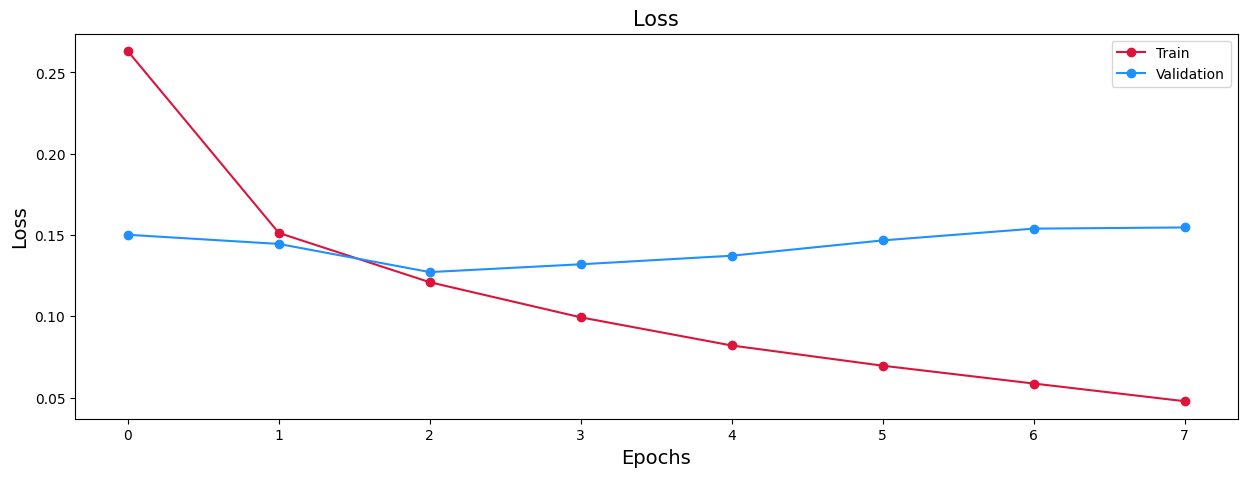

In [34]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'], linestyle='solid', marker='o', color='crimson', label='Train')
plt.plot(history.history['val_loss'], linestyle='solid', marker='o', color='dodgerblue', label='Validation')
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel('Loss',fontsize=14)
plt.title('Loss', fontsize=15)
plt.legend(loc='best')
fig.savefig(f'{MODEL_PATH}/evaluation.png', bbox_inches='tight')
plt.show()

Reload the model

In [36]:
from tensorflow.train import latest_checkpoint
with strategy.scope():
        reloaded_model = create_model(optimizer)
        # reloaded_model.load_weights(latest_checkpoint(checkpoint_dir))
        reloaded_model.load_weights(f'{MODEL_PATH}/weights.h5')
        reloaded_model.summary()

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


KerasTensor(type_spec=TensorSpec(shape=(None, 3072), dtype=tf.float32, name=None), name='tf.__operators__.getitem_1/strided_slice:0', description="created by layer 'tf.__operators__.getitem_1'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 token_type_ids (InputLayer  [(None, 256)]                0         []                         

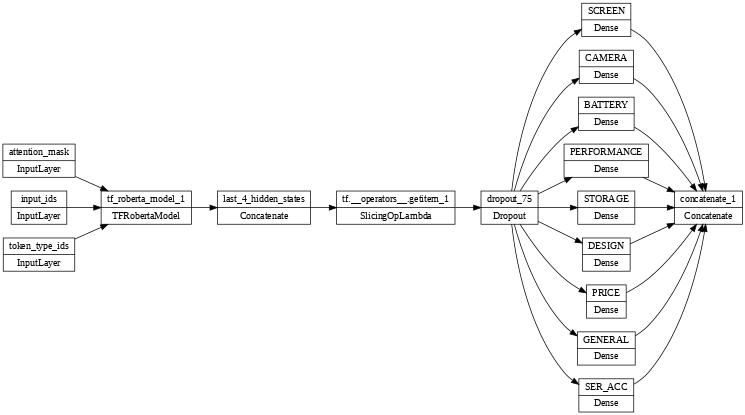

In [37]:
from tensorflow.keras.utils import plot_model
plot_model(reloaded_model, to_file=f'{MODEL_PATH}/architecture.png', rankdir='LR', dpi=52)

Prediction

In [38]:
y_test_argmax = np.argmax(y_test, axis=-1)
y_test_argmax

array([[1, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 1, 1, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 1, 1]])

Predict on test data

In [39]:
def predict(model, inputs, batch_size=1, verbose=0):
    y_pred = model.predict(inputs, batch_size=batch_size, verbose=verbose)
    y_pred = y_pred.reshape(len(y_pred), -1, 4)
    return np.argmax(y_pred, axis=-1) # sentiment values (position that have max value)

In [40]:
def print_acsa_pred(id2pol_mapping, aspects, sentence_pred):
    sentiments = map(lambda x: id2pol_mapping[x], sentence_pred)
    for aspect, sentiment in zip(aspects, sentiments):
        if sentiment != 'None': print(f'=> {aspect},{sentiment}')

In [41]:
with strategy.scope():
    y_pred = predict(reloaded_model, test_tf_dataset, BATCH_SIZE, verbose=1)
    reloaded_model.evaluate(test_tf_dataset, batch_size=BATCH_SIZE, verbose=1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
131/131 [==============================] - 36s 114ms/step


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
131/131 [==============================] - 23s 72ms/step - loss: 0.1600


In [42]:
print('Example:', df_test['comment'][0])
print_acsa_pred(id2pol_mapping, aspects, y_pred[0])

Example: Điện thoải ổn. Facelock cực nhanh, vân tay ôk , màn hình lớn, pin trâu ( liên quân , Zalo, YouTube ) một ngày mất khoảng 45 % ) tuy chỉ chip 439 nhưng rất mượt. Đa nhiệm khá ổn
=> SCREEN,Positive
=> BATTERY,Positive
=> PERFORMANCE,Positive
=> GENERAL,Positive


Predict random text

In [43]:
annotator = VnCoreNLP('/content/drive/MyDrive/Colab Notebooks/VnCoreNLP/VnCoreNLP-1.1.1.jar')

In [46]:
example_input = text_preprocess(input('Enter your sentence: '))
tokenized_input = tokenizer(example_input, padding='max_length', truncation=True)
features = {x: [[tokenized_input[x]]] for x in tokenizer.model_input_names}

with strategy.scope():
    pred = predict(reloaded_model, Dataset.from_tensor_slices(features))
    print_acsa_pred(id2pol_mapping, aspects, pred[0])

Enter your sentence: điện thoại xước màn hình , battery bị nóng quá mức
=> PERFORMANCE,Negative
=> DESIGN,Negative
